# RADIA Example 4: Uniformly Magnetized Sphere

This example creates a polyhedral approximation to a uniformly
magnetized sphere. Before working through this example, you should
successfully complete (or at least understand) Example&#160;1.

This example illustrates the creation of a polyhedral volume using
the function `ObjMltExtPgn`. In particular, we create a magnetized
polyhedron with magnetization $\mu_oM=\,$1&#160;Tesla. We then
compute the magnetic field produced by this polyhedron and show it
to be roughly uniform within the polyhedral volume. The field has
magnitude 2/3&#8239;Tesla, as expected from an analytical calculation.

to be roughly uniform within the polyhedral volume. The field, as
expected from an analytical calculation, has magnitude
2/3&#8239;Tesla [J.D.&#8239;Jackson, _Electrodynamics_, 3rd ed.,
§&#8239;5.10].

Feel free to experiment: Modify some of the parameters, re-execute
the relevant cells, and examine how the results vary with the
resolution. To learn more, consult the
[Radia documentation](
  https://www.esrf.eu/Accelerators/Groups/InsertionDevices/Software/Radia/Documentation
  "RADIA documentation at ESRF").

## _Import Radia and other packages_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.constants as sc
import numpy as np
import time as tm
from math import *

import radia as rad
from uti_plot import *
import ipywidgets
from jupyter_rs_radia import radia_viewer

## _Define the geometry_

Here we define functions to create a polyhedral approximation to
a uniformly magnetized sphere. The approximation uses multiple
layers of extruded polygons—see the documentation for the _Radia_
function `ObjMltExtPgn()`.

In this first version, the layers all have equal thickness:

In [2]:
def magnetic_sphere_eqz(r, n_phi, n_z, M):
    '''
    Create a polyhedral approximation to a uniformly magnetized sphere.
    arguments:
      r     = radius of the sphere
      n_phi = number of azimuthal intervals
      n_z   = number of vertical intervals
              (an even value yields vertices on the equator)
      M     = magnetization
    result: Radia representation of
      a uniformly magnetized sphere
    '''
    dphi = 2. * pi / n_phi
    dz   = 2. * r  / n_z
    zs   = -r + dz * np.arange(1, n_z)   # uniformly-spaced z values
    rs   = r * np.cos(np.arcsin(zs / r)) # radii at the given z values
    # polygonal approximation to unit circle
    circ = np.transpose([np.cos(dphi * np.arange(n_phi)), np.sin(dphi * np.arange(n_phi))])

    # construct interior planes of vertices
    slices = [[((r * cos(asin(z / r))) * circ).tolist(), z] for z in zs]
    # and tack on the north and south poles
    n_pole = [ [[ [0.,0.] ], +r] ]
    s_pole = [ [[ [0.,0.] ], -r] ]
    all_slices = s_pole + slices + n_pole

    # create the “sphere”
    sphere = rad.ObjMltExtPgn(all_slices, M)
    # apply color
    rad.ObjDrwAtr(sphere, [1.0, 0.5, 1.0])

    return rad.ObjCnt([sphere])

In this second version, the layers all subtend a common polar angle:

In [3]:
def magnetic_sphere_eqang(r, n_phi, n_th, M):
    '''
    Create a polyhedral approximation to a uniformly magnetized sphere.
    arguments:
      r     = radius of the sphere
      n_phi = number of azimuthal intervals
      n_th  = number of polar intervals
              (an even value yields vertices on the equator)
      M     = magnetization
    result: Radia representation of
      a uniformly magnetized sphere
    '''
    dphi = 2. * pi / n_phi
    dth  = pi / n_th
    # z values at uniformly-spaced polar angles
    zs   = r * np.cos(dth * np.arange(1, n_th))
    # polygonal approximation to unit circle
    circ = np.transpose([np.cos(dphi * np.arange(n_phi)), np.sin(dphi * np.arange(n_phi))])

    # construct interior planes of vertices
    slices = [[((r * cos(asin(z / r))) * circ).tolist(), z] for z in zs]
    # and tack on the north and south poles
    n_pole = [ [[ [0.,0.] ], +r] ] 
    s_pole = [ [[ [0.,0.] ], -r] ] 
    all_slices = n_pole + slices + s_pole

    # create the “sphere”
    sphere = rad.ObjMltExtPgn(all_slices, M)
    # apply color
    rad.ObjDrwAtr(sphere, [1.0, 0.5, 1.0])

    return rad.ObjCnt([sphere])

# Load STL Sphere

In [4]:
import numpy as np
import pymesh
import trimesh
import plotly.graph_objects as go

In [5]:
sphere_mesh = pymesh.meshio.load_mesh('test_sphere.stl')

In [6]:
# Sphere starts with a radius of 12.5 (STL is unitless)
scale_factor = 12.5

In [7]:
# sphere_mesh = trimesh.Trimesh(vertices=pm_mesh.vertices,
#                               faces=pm_mesh.faces)

In [8]:
# Radia uses 1-based indexing
reindex_faces = sphere_mesh.faces + 1
# Resize our sphere to match others in the example
vertices_resize = sphere_mesh.vertices / scale_factor

#### Create sphere from list of vertices and indices of vertices forming each face

In [9]:
rad_sphere = rad.ObjPolyhdr(vertices_resize.tolist(), reindex_faces.tolist(), [1,0,0])

In [10]:
mag_sphere_stl = rad.ObjCnt([rad_sphere])

## _Build and display the geometry_

You may place _both_ geometries in the _Radia Viewer_.
Use the _Geometry_ pop-up menu to select which one
to display.

In [11]:
# create the magnet, apply color, and place in a Radia container
mag_sphere_z = magnetic_sphere_eqz(  1, 15, 16, [1,0,0])
mag_sphere_a = magnetic_sphere_eqang(1, 15, 16, [1,0,0])

# set up the radia viewer and display the magnet
rv = radia_viewer.RadiaViewer()
rv.add_geometry('Magnetized Sphere — eq. Z', mag_sphere_z)
rv.add_geometry('Magnetized Sphere — eq. θ', mag_sphere_a)
rv.add_geometry('Magnetized Sphere — STL', mag_sphere_stl)
rv.display()

RadiaViewer(children=(Viewer(children=(VTK(layout=Layout(margin='auto', min_width='25%', width='50%'), model_d…

## _Magnetic field values_

Evaluate the magnetic field at the center of the sphere,
and confirm that it is roughly 2/3 the assigned magnetization.

In [12]:
print('Field at center (eq.Z) = ', rad.Fld(mag_sphere_z, 'b', [0,0,0]))
print('Field at center (eq.θ) = ', rad.Fld(mag_sphere_a, 'b', [0,0,0]))
print('Field at center (STL) = ',  rad.Fld(mag_sphere_stl, 'b', [0,0,0]))

Field at center (eq.Z) =  [0.6670173180687754, 2.652771665528908e-16, 4.87890977618477e-17]
Field at center (eq.θ) =  [0.6647068515362451, 5.3249573262088845e-17, 3.239731616658248e-17]
Field at center (STL) =  [0.6666658501646548, -7.733439689888787e-14, -1.7087168116390215e-15]


Next, we compare the horizontal magnetization $\mu_0 M_x$ and
field $B_x$ as functions of the transverse coördinate $y$.
In particular, we confirm that, as expected, the magnetic
field inside the sphere is essentially uniform at 2/3 the
assigned magnetization. And outside the sphere, the magnetization
vanishes, while the magnetic field decays as $1/r^3$, as
expected for a magnetic dipole.

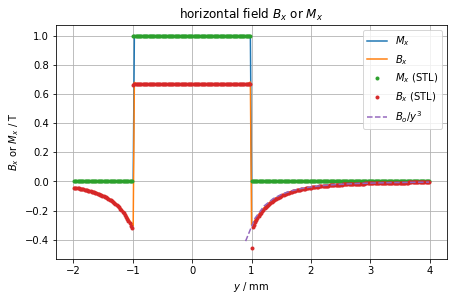

In [13]:
ys = np.linspace(-1.99, 3.99, 301)
Mx_v_Y = rad.Fld(mag_sphere_a, 'mx', [[0, y, 0] for y in ys])
Bx_v_Y = rad.Fld(mag_sphere_a, 'bx', [[0, y, 0] for y in ys])

Mx_v_Y_stl = rad.Fld(mag_sphere_stl, 'mx', [[0, y, 0] for y in ys])
Bx_v_Y_stl = rad.Fld(mag_sphere_stl, 'bx', [[0, y, 0] for y in ys])

plt.figure(figsize=(7,4.3))
# plt.plot(ys, Mx_v_Y, 'orange', label = r'$M_x$')
# plt.plot(ys, Bx_v_Y, label = r'$B_x$')
plt.plot(ys, Mx_v_Y, label = r'$M_x$')
plt.plot(ys, Bx_v_Y, label = r'$B_x$')

plt.plot(ys, Mx_v_Y_stl, '.', label = r'$M_x$ (STL)')
plt.plot(ys, Bx_v_Y_stl, '.', label = r'$B_x$ (STL)')

yy = np.linspace(0.90, 3.99, 21)
b0 = rad.Fld(mag_sphere_a, 'bx', [0, 1.001, 0])
plt.plot(yy, b0 / yy**3, '--', label = r'$B_o/y^3$')
plt.title(r'horizontal field $B_x$ or $M_x$')
plt.xlabel(r'$y$ / mm')
plt.ylabel(r'$B_x$ or $M_x$ / T')
plt.grid()
plt.legend()
plt.show()

If you look more somewhat more closely at the edge of the
sphere, you will notice that the field drops off well
_before_ the radius, at $y=$&#160;1&#8239;mm:

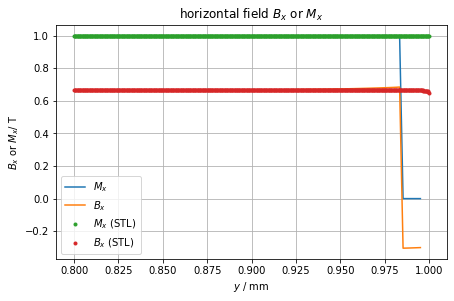

In [14]:
ys = np.linspace(0.800, 0.995, 101)
Mx_v_Y = rad.Fld(mag_sphere_a, 'mx', [[0, y, 0] for y in ys])
Bx_v_Y = rad.Fld(mag_sphere_a, 'bx', [[0, y, 0] for y in ys])

plt.figure(figsize=(7,4.3))
plt.plot(ys, Mx_v_Y, label = r'$M_x$')
plt.plot(ys, Bx_v_Y, label = r'$B_x$')

ys = np.linspace(0.800, 0.9999, 501)
Mx_v_Y_stl = rad.Fld(mag_sphere_stl, 'mx', [[0, y, 0] for y in ys])
Bx_v_Y_stl = rad.Fld(mag_sphere_stl, 'bx', [[0, y, 0] for y in ys])

plt.plot(ys, Mx_v_Y_stl, '.', label = r'$M_x$ (STL)')
plt.plot(ys, Bx_v_Y_stl, '.', label = r'$B_x$ (STL)')

plt.title(r'horizontal field $B_x$ or $M_x$')
plt.xlabel(r'$y$ / mm')
plt.ylabel(r'$B_x$ or $M_x$/ T')
plt.grid()
# plt.xlim(0.75,1.05)
plt.legend()
plt.show()

This is a consequence of the finite resolution in our
representation of the sphere. You can easily test this
by making similar plots at different resolutions:

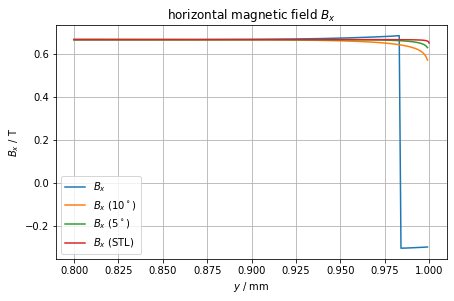

In [15]:
mag_sphere_a1 = magnetic_sphere_eqang(1, 36, 36, [1,0,0])
mag_sphere_a2 = magnetic_sphere_eqang(1, 72, 72, [1,0,0])

ys = np.linspace(0.800, 0.999, 201)
Bx_v_Y0 = rad.Fld(mag_sphere_a,  'bx', [[0, y, 0] for y in ys])
Bx_v_Y1 = rad.Fld(mag_sphere_a1, 'bx', [[0, y, 0] for y in ys])
Bx_v_Y2 = rad.Fld(mag_sphere_a2, 'bx', [[0, y, 0] for y in ys])

plt.figure(figsize=(7,4.3))
plt.plot(ys, Bx_v_Y0, label = r'$B_x$')
plt.plot(ys, Bx_v_Y1, label = r'$B_x$ ($10^\circ$)')
plt.plot(ys, Bx_v_Y2, label = r'$B_x$ ($5^\circ$)')
ys = np.linspace(0.800, 0.9999, 501)
Bx_v_Y_STL = rad.Fld(mag_sphere_stl,  'bx', [[0, y, 0] for y in ys])
plt.plot(ys, Bx_v_Y_STL, label = r'$B_x$ (STL)')

plt.title(r'horizontal magnetic field $B_x$')
plt.xlabel(r'$y$ / mm')
plt.ylabel(r'$B_x$ / T')
plt.grid()
# plt.xlim(0.75,1.05)
plt.legend()
plt.show()

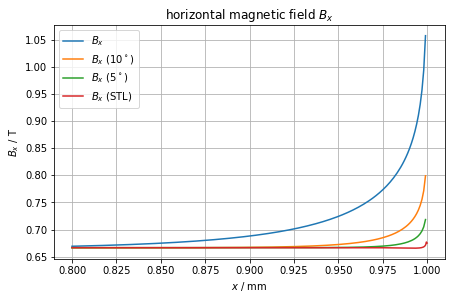

In [16]:
xs = np.linspace(0.800, 0.999, 201)
Bx_v_X0 = rad.Fld(mag_sphere_a,  'bx', [[x, 0, 0] for x in xs])
Bx_v_X1 = rad.Fld(mag_sphere_a1, 'bx', [[x, 0, 0] for x in xs])
Bx_v_X2 = rad.Fld(mag_sphere_a2, 'bx', [[x, 0, 0] for x in xs])

plt.figure(figsize=(7,4.3))
plt.plot(xs, Bx_v_X0, label = r'$B_x$')
plt.plot(xs, Bx_v_X1, label = r'$B_x$ ($10^\circ$)')
plt.plot(xs, Bx_v_X2, label = r'$B_x$ ($5^\circ$)')

xs = np.linspace(0.800, 0.9999, 501)
Bx_v_X_STL = rad.Fld(mag_sphere_stl,  'bx', [[x, 0, 0] for x in xs])
plt.plot(xs, Bx_v_X_STL, label = r'$B_x$ (STL)')

plt.title(r'horizontal magnetic field $B_x$')
plt.xlabel(r'$x$ / mm')
plt.ylabel(r'$B_x$ / T')
plt.grid()
# plt.xlim(0.75,1.05)
plt.legend()
plt.show()

In addition, you might look at the field along the $x$-axis,
parallel to the magnetization vector.

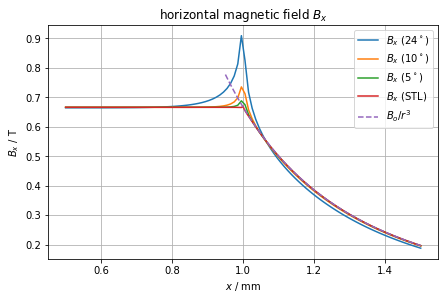

In [19]:
xs = np.linspace(0.500, 1.500, 100)
Bx_v_X0 = rad.Fld(mag_sphere_a,  'bx', [[x, 0, 0] for x in xs])
Bx_v_X1 = rad.Fld(mag_sphere_a1, 'bx', [[x, 0, 0] for x in xs])
Bx_v_X2 = rad.Fld(mag_sphere_a2, 'bx', [[x, 0, 0] for x in xs])

plt.figure(figsize=(7,4.3))
plt.plot(xs, Bx_v_X0, label = r'$B_x$ ($24^\circ$)')
plt.plot(xs, Bx_v_X1, label = r'$B_x$ ($10^\circ$)')
plt.plot(xs, Bx_v_X2, label = r'$B_x$ ($5^\circ$)')

xs = np.linspace(0.500, 1.500, 500)
Bx_v_X_stl = rad.Fld(mag_sphere_stl,  'bx', [[x, 0, 0] for x in xs])
plt.plot(xs, Bx_v_X_stl, label = r'$B_x$ (STL)')
xx = np.linspace(0.950, 1.500, 100)
plt.plot(xx, (2/3) / xx**3, '--', label = r'$B_o/r^3$')
plt.title(r'horizontal magnetic field $B_x$')
plt.xlabel(r'$x$ / mm')
plt.ylabel(r'$B_x$ / T')
plt.grid()
# plt.xlim(0.75,1.05)
plt.legend()
plt.show()

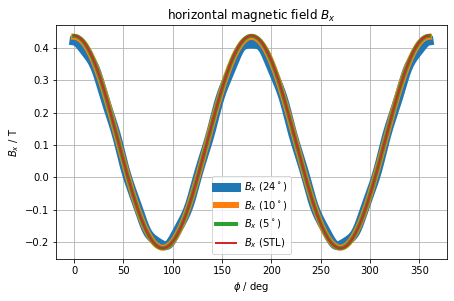

In [20]:
r2d = 180 / pi
ro = 1.150
phi = np.linspace(0, 2*pi, 360)
Bx_v_Ph0 = rad.Fld(mag_sphere_a,  'bx', [[ro * cos(f), ro * sin(f), 0] for f in phi])
Bx_v_Ph1 = rad.Fld(mag_sphere_a1, 'bx', [[ro * cos(f), ro * sin(f), 0] for f in phi])
Bx_v_Ph2 = rad.Fld(mag_sphere_a2, 'bx', [[ro * cos(f), ro * sin(f), 0] for f in phi])

plt.figure(figsize=(7,4.3))
plt.plot(phi * r2d, Bx_v_Ph0, label = r'$B_x$ ($24^\circ$)', lw=9)
plt.plot(phi * r2d, Bx_v_Ph1, label = r'$B_x$ ($10^\circ$)', lw=6)
plt.plot(phi * r2d, Bx_v_Ph2, label = r'$B_x$ ($5^\circ$)' , lw=4)

phi = np.linspace(0, 2*pi, 720)
Bx_v_Ph_stl = rad.Fld(mag_sphere_stl,  'bx', [[ro * cos(f), ro * sin(f), 0] for f in phi])
plt.plot(phi * r2d, Bx_v_Ph_stl, label = r'$B_x$ (STL)' , lw=2)
# xx = np.linspace(0.90, 1.50, 31)
# b0 = rad.Fld(mag_sphere_a2, 'bx', [1.001, 0, 0])
# plt.plot(xx, (2/3) / xx**3, '--', label = r'$B_o/r^3$')
plt.title(r'horizontal magnetic field $B_x$')
plt.xlabel(r'$\phi$ / deg')
plt.ylabel(r'$B_x$ / T')
plt.grid()
# plt.xlim(0.75,1.05)
plt.legend()
plt.show()